XGBoost

### The XGBoost Advantage

- Regularization:
Standard GBM implementation has no regularization like XGBoost, therefore it also helps to reduce overfitting.
In fact, XGBoost is also known as ‘regularized boosting‘ technique.
- Parallel Processing:
XGBoost implements parallel processing and is blazingly faster as compared to GBM.
But hang on, we know that boosting is sequential process so how can it be parallelized? We know that each tree can be built only after the previous one, so what stops us from making a tree using all cores? I hope you get where I’m coming from. Check this link out to explore further.
XGBoost also supports implementation on Hadoop.
- High Flexibility
XGBoost allow users to define custom optimization objectives and evaluation criteria.
This adds a whole new dimension to the model and there is no limit to what we can do.
Handling Missing Values
XGBoost has an in-built routine to handle missing values.
User is required to supply a different value than other observations and pass that as a parameter. XGBoost tries different things as it encounters a missing value on each node and learns which path to take for missing values in future.
- Tree Pruning:
A GBM would stop splitting a node when it encounters a negative loss in the split. Thus it is more of a greedy algorithm.
XGBoost on the other hand make splits upto the max_depth specified and then start pruning the tree backwards and remove splits beyond which there is no positive gain.
Another advantage is that sometimes a split of negative loss say -2 may be followed by a split of positive loss +10. GBM would stop as it encounters -2. But XGBoost will go deeper and it will see a combined effect of +8 of the split and keep both.
- Built-in Cross-Validation
XGBoost allows user to run a cross-validation at each iteration of the boosting process and thus it is easy to get the exact optimum number of boosting iterations in a single run.
This is unlike GBM where we have to run a grid-search and only a limited values can be tested.
- Continue on Existing Model
User can start training an XGBoost model from its last iteration of previous run. This can be of significant advantage in certain specific applications.
GBM implementation of sklearn also has this feature so they are even on this point.

In [9]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Read Data

In [10]:
import numpy as np
import pandas as pd
import math
import re

from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


df_train = pd.read_csv('data/train.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
df_train_label = df_train[["Id", "SalePrice"]]
df_train = df_train.drop('SalePrice', axis=1)

df_train = df_train.set_index("Id")
df_train_label = df_train_label.set_index("Id")

df_test = pd.read_csv('data/test.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')

test_null_columns=df_test.columns[df_test.isnull().any()] 
train_null_columns=df_train.columns[df_train.isnull().any()] 
test_null_only_ColIdx = test_null_columns.difference(train_null_columns)

test_null_only_RowIdx = [ df_test[df_test[idx].isnull()].index.tolist() for idx in test_null_only_ColIdx ]
test_null_only_RowIdx = list ( set(x for l in test_null_only_RowIdx for x in l) )

problematicTestSet = df_test.loc[ df_test.index.isin( test_null_only_RowIdx ) ]

fineTestSet = df_test.loc[ ~df_test.index.isin( test_null_only_RowIdx ) ]  #1447 records

problematicTestSet= problematicTestSet.set_index("Id")
fineTestSet = fineTestSet.set_index("Id")
df_test = df_test.set_index("Id")

df = pd.concat([df_train,df_test], axis=0, sort=True)

problematicTestSet.index

Int64Index([1556, 1916, 1946, 2121, 2152, 2189, 2217, 2251, 2474, 2490, 2577, 2905], dtype='int64', name='Id')

In [11]:
from preprocess import impute
df_label_count, encodedDic = impute( df, False) 
df_test = df_label_count[df_label_count.index >= min( df_test.index ) ]
df_train = df_label_count[df_label_count.index < min( df_test.index ) ]

In [12]:
df_train_label = df_train_label.astype(int)
df_train_label_log = np.log( df_train_label )
#df_train_label.hist()
#df_train_label_log.hist()


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_train, df_train_label_log, test_size=0.2, random_state=0)

In [14]:
def evaluate(model, test_features, test_labels): 
    
    predictions = model.predict(test_features).ravel()  
    residuals = test_labels - predictions
    rmse = np.sqrt(np.mean((test_labels - predictions) ** 2))
    rmsle = np.sqrt(np.mean((np.log1p(predictions) - np.log1p(test_labels))**2))    
    pred = pd.DataFrame( {'residuals': residuals.values, 'predictions': predictions} )
    pred.set_index(residuals.index)
    
    return [rmse, rmsle, pred]

In [9]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# A parameter grid for XGBoost
#params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
#'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}

params = [{'n_estimators' : np.arange(600, 1000, 100),
           'max_depth': [2,3,4,5] ,
           'colsample_bytree':[i/10.0 for i in range(6,11)],
           'min_child_weight':[4,5],
           'gamma':[i/10.0 for i in range(3,6)],
           'subsample':[i/10.0 for i in range(6,11)],
           'learning_rate':  [ 0.001 ,0.01, 0.1, 0.2 ] }]

# Initialize XGB and GridSearch
model_xgb = xgb.XGBRegressor( nthread=3 ) 

grid = GridSearchCV(model_xgb, params)
grid.fit(df_train, df_train_label_log)


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=3, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': array([600, 700, 800, 900]), 'max_depth': [2, 3, 4, 5], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], 'min_child_weight': [4, 5], 'gamma': [0.3, 0.4, 0.5], 'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], 'learning_rate': [0.001, 0.01, 0.1, 0.2]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [10]:
print(grid.best_params_)
model_xgb_best = grid.best_estimator_

{'colsample_bytree': 0.9, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 900, 'subsample': 0.7}


In [12]:

cvrmse = np.sqrt(-cross_val_score( model_xgb_best , df_train, df_train_label_log, scoring="neg_mean_squared_error", cv = 10) )
print( cvrmse.mean() )
print( cvrmse.std() )
cvrmse

0.1304198763300106
0.014917556784812132


array([0.11908284, 0.11404583, 0.11863477, 0.15585583, 0.15104988,
       0.11557143, 0.12957418, 0.11792571, 0.14299653, 0.13946176])

RMSE = 0.1104
RMSLE = 0.0085


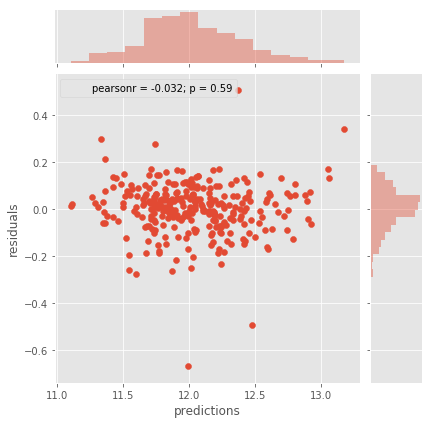

In [15]:
rmse, rmsle, pred = evaluate(model_xgb_best, X_test, y_test['SalePrice'] )
print('RMSE = {:0.4f}'.format(rmse))
print('RMSLE = {:0.4f}'.format(rmsle))
sns.jointplot(x = "predictions", y = "residuals",  data=pred )

In [18]:
import xgboost as xgb
param = {'colsample_bytree': 0.9, 
         'gamma': 0.3, 
         'learning_rate': 0.1, 
         'max_depth': 4, 
         'min_child_weight': 5, 
         'n_estimators': 900, 
         'subsample': 0.7}

model_xgb_best = xgb.XGBRegressor( colsample_bytree= 0.9,
                                  gamma = 0.3,
                                  learning_rate = 0.1,
                                  max_depth = 4,
                                  min_child_weight = 5,
                                  n_estimators = 900,
                                  subsample = 0.7,
                                  thread = -1)
model_xgb_best.fit(df_train, df_train_label_log)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0.3, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=5, missing=None,
       n_estimators=900, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.7, thread=-1)

array([0.00358423, 0.00358423, 0.00358423, 0.00358423, 0.00358423,
       0.00358423, 0.00358423, 0.00716846, 0.00716846, 0.00716846,
       0.00716846, 0.00716846, 0.00716846, 0.00716846, 0.00716846,
       0.00716846, 0.00716846, 0.00716846, 0.00716846, 0.00716846,
       0.01075269, 0.01075269, 0.01075269, 0.01075269, 0.01433692,
       0.01433692, 0.01433692, 0.01433692, 0.01433692, 0.01433692,
       0.01792115, 0.02150538, 0.02150538, 0.02150538, 0.02508961,
       0.02508961, 0.02508961, 0.02867384, 0.0358423 , 0.0358423 ,
       0.0358423 , 0.04301075, 0.05017921, 0.05376344, 0.05734767,
       0.06451613, 0.06810036, 0.1218638 ], dtype=float32)

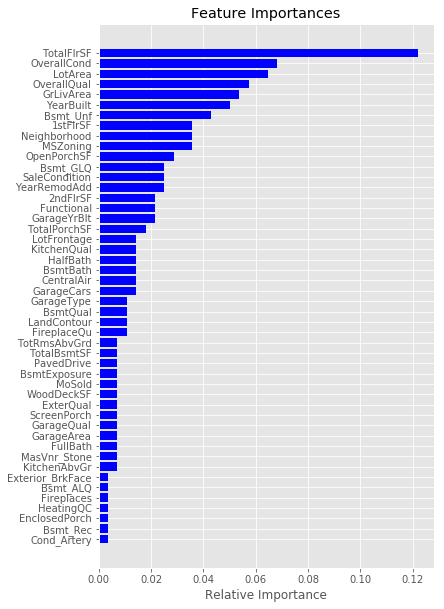

In [58]:
plt.rcParams['figure.figsize'] = (6.0, 10.0)
features= df_train.columns
importances = model_xgb_best.feature_importances_

indices = np.argsort(-importances)[0:48]
indices = indices[::-1]

plt.title('Feature Importances')
#plt.barh( range(len(indices)), importances[indices], color='b', align='center')
plt.barh( range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

importances[indices]

In [17]:
d = {  'SalePrice': np.expm1 ( model_xgb_best.predict(df_test) )    }
sub = pd.DataFrame(data = d, dtype=np.int64, index = df_test.index )
sub.to_csv('Xgb.csv')

In [18]:
import pickle
with open('xgb.pkl', 'wb') as handle:
    pickle.dump(grid, handle, protocol=pickle.HIGHEST_PROTOCOL)